# Neutrino event classification

This mini-project's dataset is comprised of a number of small files containing images of simulated neutrino interactions in a hypothetical detector that looks an awful lot like the detectors of the NOvA experiment. For each neutrino interaction the images consist of two $100 \times 80$ pixel images that represent the $x \times z$ and $y \times z$ projections of the tracks of particles in the detector.

The data for this mini-project comes in the form of the following files:

| File | Description |
| ----------- | ----------- |
| neutrino1.h5 | The 1st HDF5 file containing event images and meta deta |
| $\vdots$ | The middle ones |
| neutrino200.h5| The 200th HDF5 file|


The images show the energy deposited by simulated neutrinos in a NOvA like detector. Some of the meta information in the hdf5 file is described below

| Label | Description |
| ----------- | ----------- |
| neutrino/nuenergy | Neutrino Energy (GeV) |
| neutrino/lepenergy | Lepton Energy (GeV) |
| neutrino/finalstate | Interaction |
| neutrino/finalstate | Final State |


The [PDG code](https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf) is a number which identifies the particle type (e.g electron=11, electron-neutrino=12, etc.)

The $interaction$ says what kind of interaction occured and is defined in the enumeration below.

## Machine learning tasks
1. Develop a machine learning classifier that can successfully identify $\nu_\mu$ charged-current events
2. Test your machine learning classifier and investigate how the efficiency of the classifier depends on the meta data variables shown above

### Potential extensions
1. Write a machine learning algorithm to determine the energy of the neutrino
2. Write a machine learning algorithm to determine the flavour of the neutrino
3. Write a machine learning algorithm to determine $y=$ lepton energy over neutrino energy
4. Write a machine learning algorithm to determine the number of protons or pions
5. Write a machine learning algorithm to determine the interaction mode.




In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)

2.15.0


In [2]:
import enum
class Interaction(enum.Enum):
    kNumuQE =0           # Numu CC QE interaction
    kNumuRes =1           # Numu CC Resonant interaction
    kNumuDIS = 2          # Numu CC DIS interaction
    kNumuOther = 3        # Numu CC, other than above
    kNueQE = 4            # Nue CC QE interaction
    kNueRes = 5           # Nue CC Resonant interaction
    kNueDIS = 6           # Nue CC DIS interaction
    kNueOther = 7         # Nue CC, other than above
    kNutauQE = 8          # Nutau CC QE interaction
    kNutauRes = 9         # Nutau CC Resonant interaction
    kNutauDIS =10         # Nutau CC DIS interaction
    kNutauOther =11       # Nutau CC, other than above
    kNuElectronElastic = 12# NC Nu On E Scattering
    kNC =13                # NC interaction
    kCosmic =14           # Cosmic ray background
    kOther =15            # Something else.  Tau?  Hopefully we don't use this
    kNIntType=16          # Number of interaction types, used like a vector size


class FinalState(enum.Enum):
    kNumu0tr0sh=0          # Numu CC - no track no shower
    kNumu0tr1sh=1          # Numu CC - no track  1 shower
    kNumu0tr2sh=enum.auto()          # Numu CC - no track  2 shower
    kNumu0trMsh=enum.auto()          # Numu CC - no track 3+ shower
    kNumu1tr0sh=enum.auto()          # Numu CC -  1 track no shower
    kNumu1tr1sh=enum.auto()          # Numu CC -  1 track  1 shower
    kNumu1tr2sh=enum.auto()          # Numu CC -  1 track  2 shower
    kNumu1trMsh=enum.auto()          # Numu CC -  1 track 3+ shower
    kNumu2tr0sh=enum.auto()          # Numu CC -  2 track no shower
    kNumu2tr1sh=enum.auto()          # Numu CC -  2 track  1 shower
    kNumu2tr2sh=enum.auto()          # Numu CC -  2 track  2 shower
    kNumu2trMsh=enum.auto()          # Numu CC -  2 track 3+ shower
    kNumuMtr0sh=enum.auto()          # Numu CC - 3+ track no showe
    kNumuMtr1sh=enum.auto()          # Numu CC - 3+ track  1 shower
    kNumuMtr2sh=enum.auto()          # Numu CC - 3+ track  2 showe
    kNumuMtrMsh=enum.auto()          # Numu CC - 3+ track 3+ shower

    kNue0tr0sh=enum.auto()           # Nue CC - no track no shower
    kNue0tr1sh=enum.auto()           # Nue CC - no track  1 shower
    kNue0tr2sh=enum.auto()           # Nue CC - no track  2 showe
    kNue0trMsh=enum.auto()           # Nue CC - no track 3+ shower
    kNue1tr0sh=enum.auto()           # Nue CC -  1 track no shower
    kNue1tr1sh=enum.auto()           # Nue CC -  1 track  1 shower
    kNue1tr2sh=enum.auto()           # Nue CC -  1 track  2 shower
    kNue1trMsh=enum.auto()           # Nue CC -  1 track 3+ shower
    kNue2tr0sh=enum.auto()           # Nue CC -  2 track no shower
    kNue2tr1sh=enum.auto()           # Nue CC -  2 track  1 shower
    kNue2tr2sh=enum.auto()           # Nue CC -  2 track  2 shower
    kNue2trMsh=enum.auto()           # Nue CC -  2 track 3+ shower
    kNueMtr0sh=enum.auto()           # Nue CC - 3+ track no shower
    kNueMtr1sh=enum.auto()           # Nue CC - 3+ track  1 shower
    kNueMtr2sh=enum.auto()           # Nue CC - 3+ track  2 shower
    kNueMtrMsh=enum.auto()           # Nue CC - 3+ track 3+ shower

    kNC0tr0sh=enum.auto()           # NC CC - no track no shower
    kNC0tr1sh=enum.auto()           # NC CC - no track  1 shower
    kNC0tr2sh=enum.auto()           # NC CC - no track  2 shower
    kNC0trMsh=enum.auto()           # NC CC - no track 3+ shower
    kNC1tr0sh=enum.auto()           # NC CC -  1 track no shower
    kNC1tr1sh=enum.auto()           # NC CC -  1 track  1 shower
    kNC1tr2sh=enum.auto()           # NC CC -  1 track  2 shower
    kNC1trMsh=enum.auto()           # NC CC -  1 track 3+ shower
    kNC2tr0sh=enum.auto()           # NC CC -  2 track no shower
    kNC2tr1sh=enum.auto()           # NC CC -  2 track  1 shower
    kNC2tr2sh=enum.auto()           # NC CC -  2 track  2 shower
    kNC2trMsh=enum.auto()           # NC CC -  2 track 3+ shower
    kNCMtr0sh=enum.auto()           # NC CC - 3+ track no shower
    kNCMtr1sh=enum.auto()           # NC CC - 3+ track  1 shower
    kNCMtr2sh=enum.auto()           # NC CC - 3+ track  2 shower
    kNCMtrMsh=enum.auto()           # NC CC - 3+ track 3+ shower

    kCosmicFS=enum.auto()           # Cosmic ray background
    kOtherFS=enum.auto()            # Something else.  Tau?  Hopefully we don't use this
    kNFStType=enum.auto()            # Number of interaction types, used like a vector size



In [3]:
# import the urllib library
import urllib.request

# Copy a network object to a local file
urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino1.h5', "neutrino1.h5")
urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino2.h5', "neutrino2.h5")

#Open the local h5 file with h5py
df1=h5py.File('neutrino1.h5','r')
df2=h5py.File('neutrino2.h5','r')

In [4]:
#Print the keys in the neutrino meta data
print(df2.keys())
print(df2['neutrino'].keys())

#Get an numpy array containing the event image, and reshape it from flat to 2x100x80
print(np.shape(df2['cvnmap']))
print(df2['neutrino']['evt'])
event0=np.array(df1['cvnmap'][3]).reshape((2,100,80))

<KeysViewHDF5 ['cvnmap', 'neutrino']>
<KeysViewHDF5 ['cycle', 'evt', 'finalstate', 'finalstateprong', 'interaction', 'lepenergy', 'nuenergy', 'parent', 'particles', 'rec.training.trainingdata_idx', 'run', 'subevt', 'subrun', 'vtxx', 'vtxy', 'vtxz']>
(6955, 16000)
<HDF5 dataset "evt": shape (6955, 1), type "<u4">


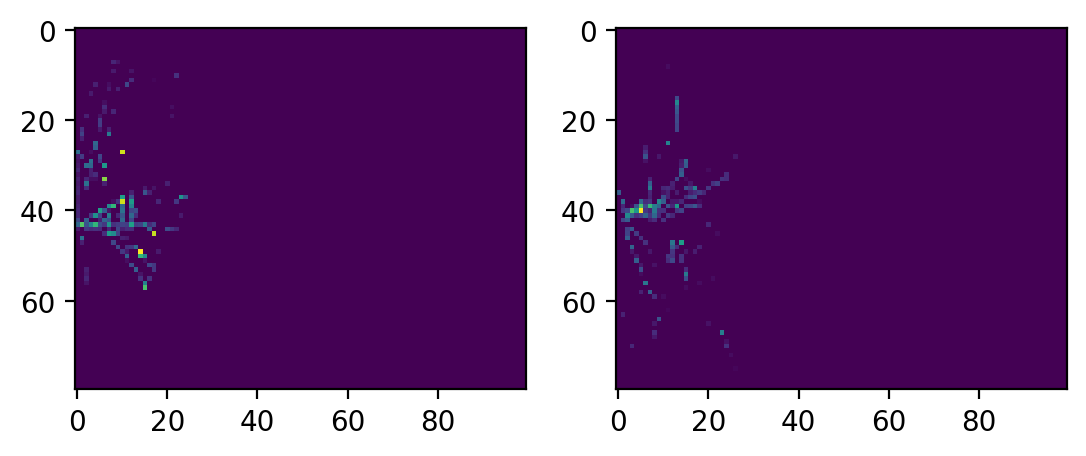

In [5]:
#Plot the first event, look it is a nice long muon track
fig, ax = plt.subplots(1,2)
b=ax[0].imshow(event0[1].T)
a=ax[1].imshow(event0[0].T)


In [6]:
print("Neutrino Final State code",df1['neutrino']['finalstate'][3])
print("Interaction was ",Interaction(df1['neutrino']['interaction'][3]))
print("Neutrino energy",df1['neutrino']['nuenergy'][3],"GeV")

Neutrino Final State code [46]
Interaction was  Interaction.kNC
Neutrino energy [13.677229] GeV


Text(0, 0.5, 'number of neutrinos')

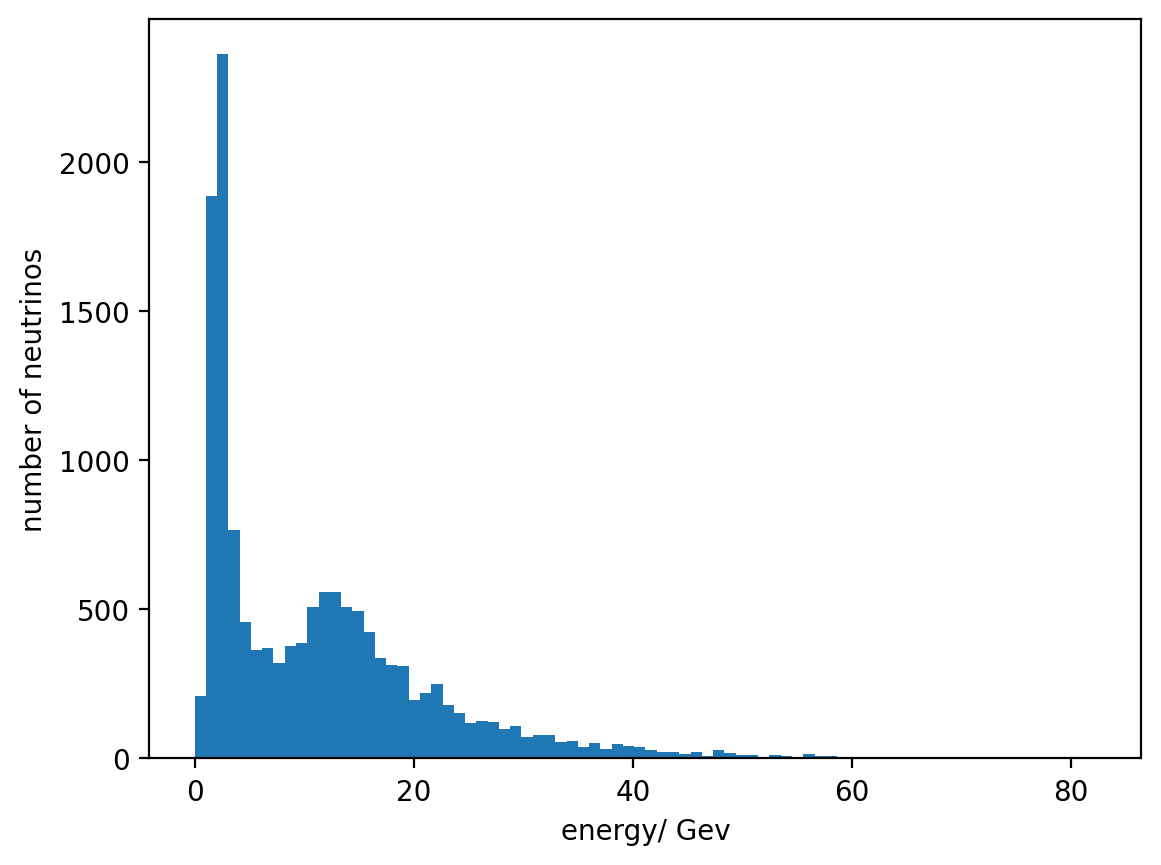

In [9]:
fs=np.array(df1['neutrino']['finalstate'])
nuenergy1=np.array(df1['neutrino']['nuenergy'])
nuenergy2=np.array(df2['neutrino']['nuenergy'])
nuenergy=np.concatenate((nuenergy1,nuenergy2),axis=0)
fig, ax = plt.subplots()
ax.hist(nuenergy,bins=80)
plt.xlabel('energy/ Gev')
plt.ylabel('number of neutrinos')

Task 1 Define a binary classifier for mu neutrino.

In [8]:
# combine image from different files
image1=np.reshape(df1['cvnmap'],(df1['cvnmap'].shape[0],100,80,2))
image2=np.reshape(df2['cvnmap'],(df2['cvnmap'].shape[0],100,80,2))
image=np.concatenate((image1, image2), axis=0)
#combine label
labels1=df1['neutrino']['interaction']
labels2=df2['neutrino']['interaction']
olabels=np.concatenate((labels1, labels2), axis=0)  #oringinal label
labels=np.where(olabels <= 3, 1, 0)  #binary label
#split train and test set
train_images, test_images, otrain_labels, otest_labels =train_test_split(image,olabels , test_size=0.2, random_state=42)
train_images, test_images, train_labels, test_labels =train_test_split(image,labels , test_size=0.2, random_state=42)



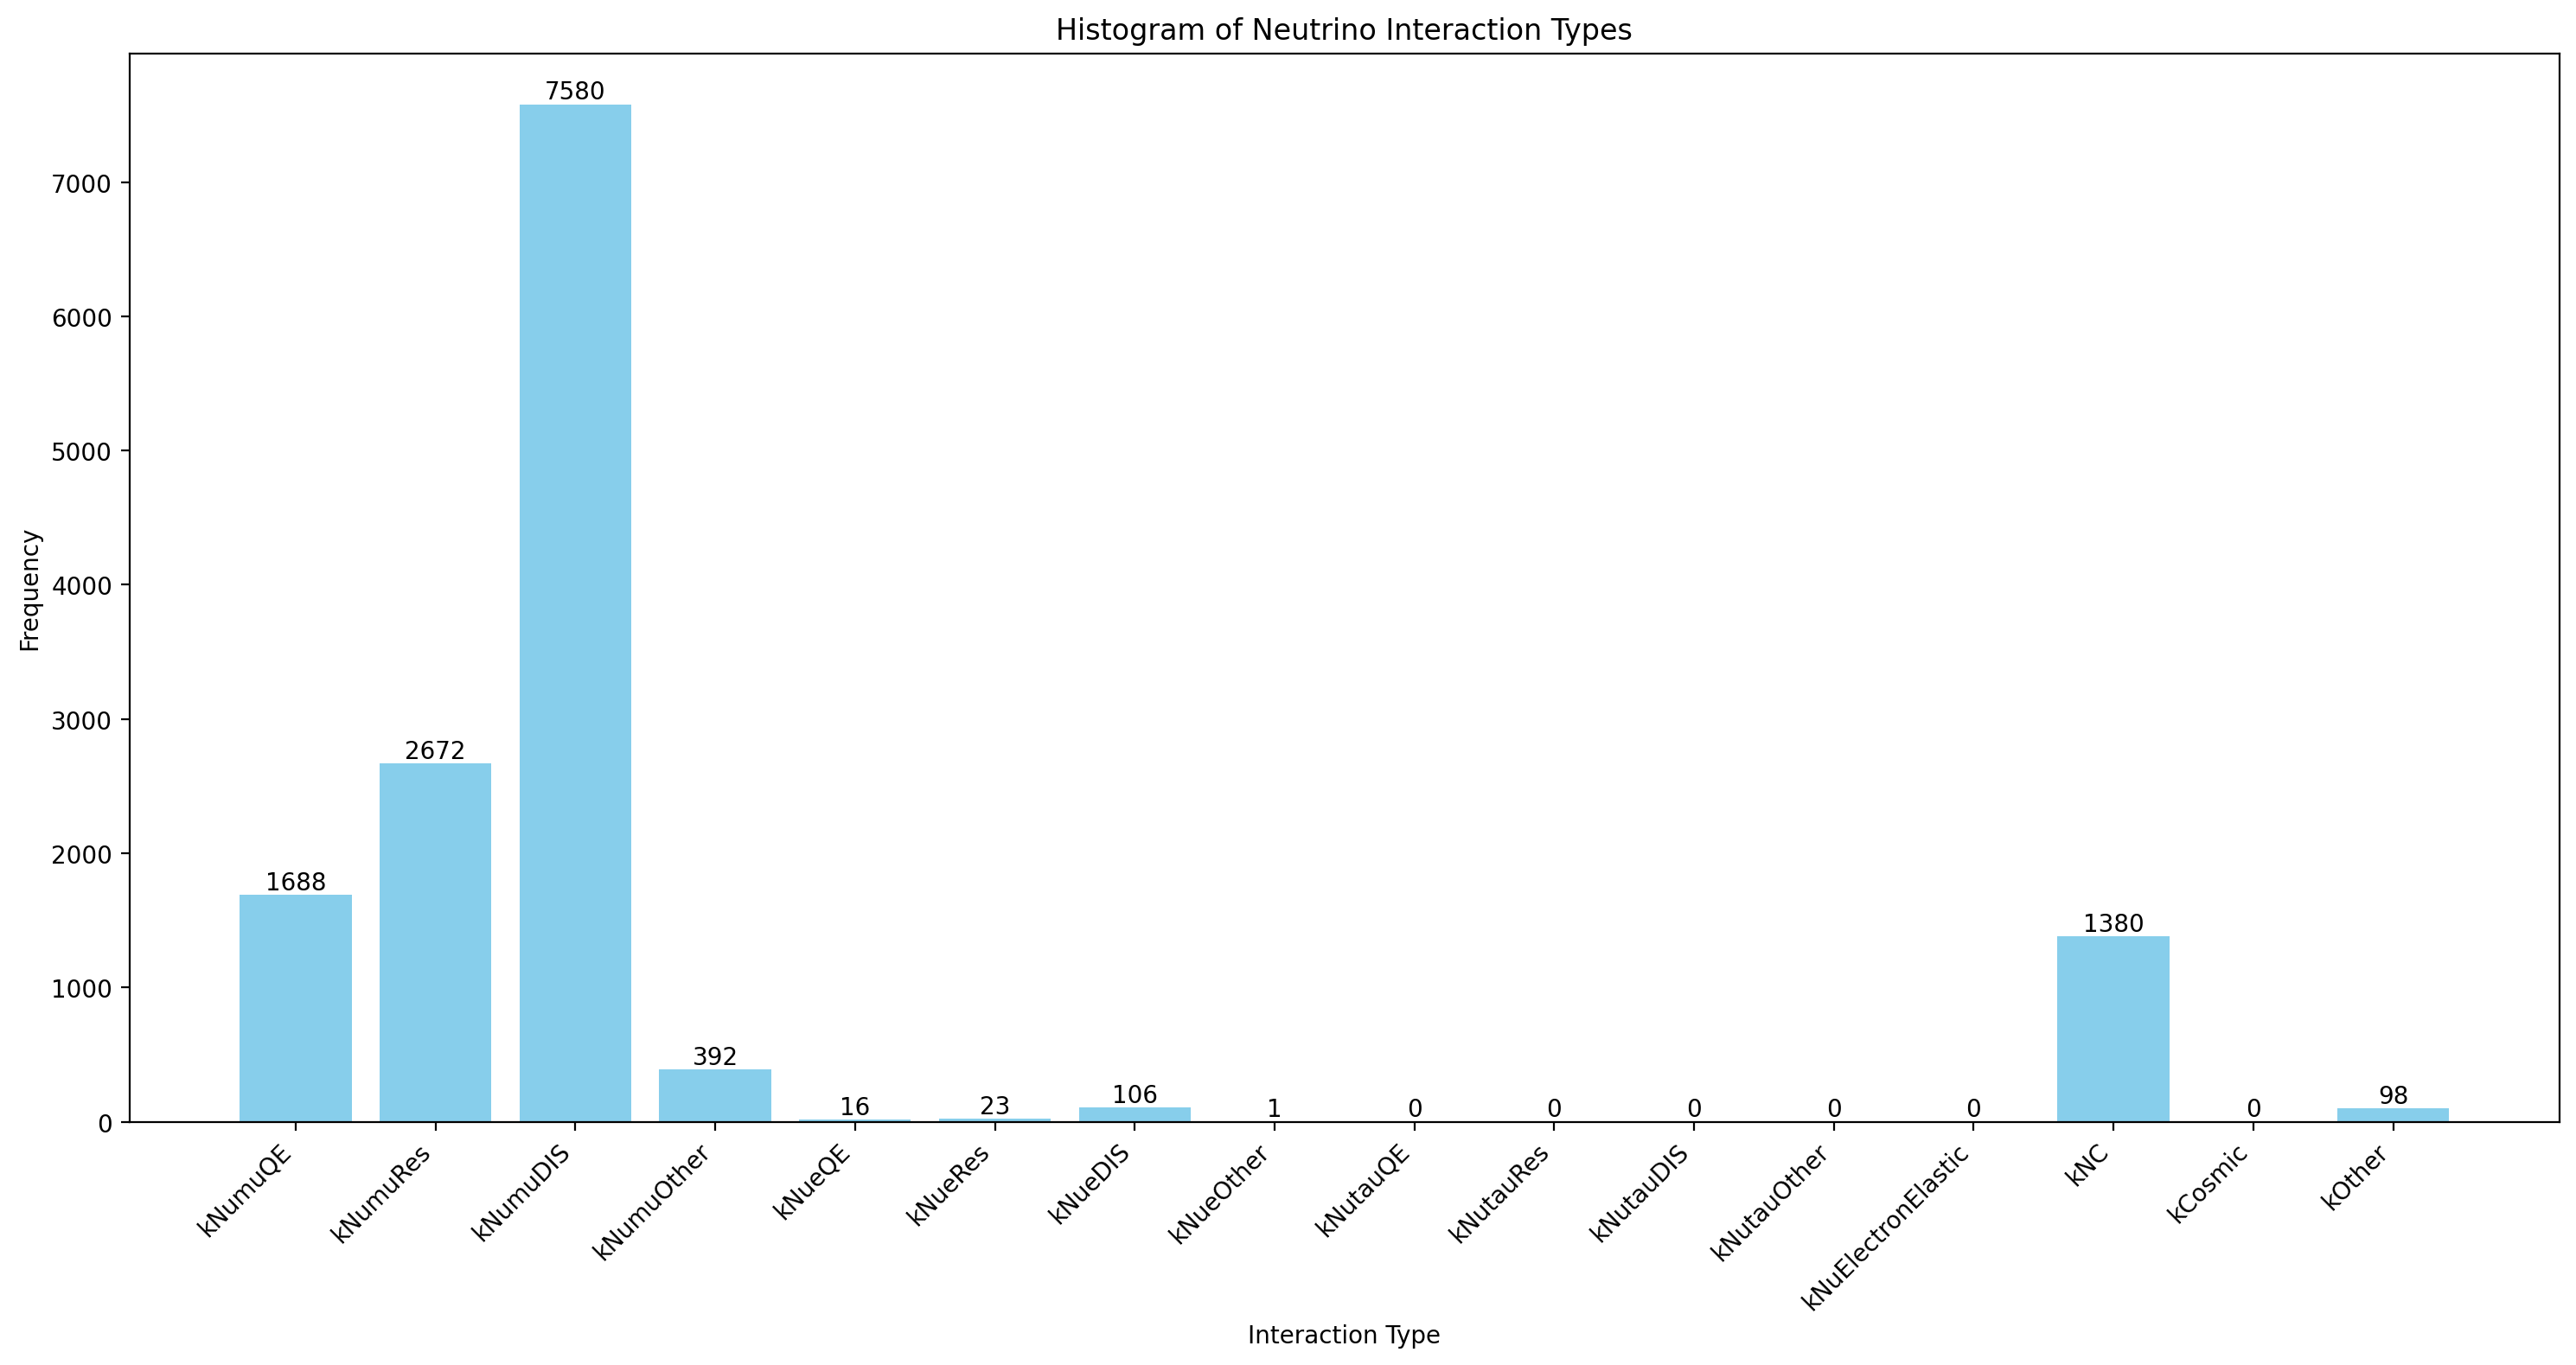

In [15]:
interaction_labels =  olabels.flatten()

# Get the list of interaction names from the enum, excluding 'kNIntType' if it's not an interaction type
interaction_names = [interaction.name for interaction in Interaction if interaction.value != 16]

# Count the occurrences of each interaction type
counts = np.bincount(interaction_labels, minlength=len(interaction_names))

# Plotting
plt.figure(figsize=(15, 8))  # Adjust figure size to ensure enough space for labels
bars = plt.bar(range(len(interaction_names)), counts, color='skyblue')

# Add labels to each bin
plt.xticks(range(len(interaction_names)), interaction_names, rotation=45, ha="right")

# Optionally, add count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

plt.xlabel('Interaction Type')
plt.ylabel('Frequency')
plt.title('Histogram of Neutrino Interaction Types')
plt.tight_layout()  # Adjust layout
plt.show()

In [31]:
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 80, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1,activation='sigmoid')  # 1 units for binary output
])

In [32]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 98, 78, 16)        304       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 49, 39, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 47, 37, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 23, 18, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 21, 16, 64)        18496     
                                                                 
 flatten_5 (Flatten)         (None, 21504)            

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images,train_labels , epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10
349/349 [==============================] - 79s 220ms/step - loss: 0.3208 - accuracy: 0.8813 - val_loss: 0.2853 - val_accuracy: 0.8890
Epoch 2/10
349/349 [==============================] - 66s 190ms/step - loss: 0.2636 - accuracy: 0.8836 - val_loss: 0.2805 - val_accuracy: 0.8879
Epoch 3/10
349/349 [==============================] - 75s 215ms/step - loss: 0.2359 - accuracy: 0.8879 - val_loss: 0.2780 - val_accuracy: 0.8872
Epoch 4/10
349/349 [==============================] - 66s 191ms/step - loss: 0.2110 - accuracy: 0.8995 - val_loss: 0.2733 - val_accuracy: 0.8850
Epoch 5/10
349/349 [==============================] - 64s 183ms/step - loss: 0.1864 - accuracy: 0.9134 - val_loss: 0.2978 - val_accuracy: 0.8915
Epoch 6/10
349/349 [==============================] - 64s 183ms/step - loss: 0.1619 - accuracy: 0.9265 - val_loss: 0.3482 - val_accuracy: 0.8875
Epoch 7/10
349/349 [==============================] - 64s 185ms/step - loss: 0.1344 - accuracy: 0.9386 - val_loss: 0.4147 - val_ac

In [ ]:
from sklearn.model_selection import train_test_split

#select DIS QE AND re DATA
DIS_indices = np.where(np.isin(olabels, [2, 6, 10]))[0]
DIS_labels = labels[DIS_indices]
DIS_images=image[DIS_indices]
DIS_olabels=olabels[DIS_indices]
# Splitting the dataset into training and testing sets
DIS_train_images, DIS_test_images, DIS_train_labels, DIS_test_labels = train_test_split(DIS_images,DIS_labels , test_size=0.2, random_state=42)

#QE
QE_indices = np.where(np.isin(olabels, [0, 4,8]))[0]
QE_labels = labels[QE_indices]
QE_olabels=olabels[QE_indices]
QE_images=image[QE_indices]
QE_train_images, QE_test_images, QE_train_labels, QE_test_labels = train_test_split(QE_images,QE_labels , test_size=0.2, random_state=42)

#RE
RE_indices = np.where(np.isin(olabels, [1,5,9]))[0]
RE_labels = labels[RE_indices]
RE_olabels=olabels[RE_indices]
RE_images=image[RE_indices]
RE_train_images, RE_test_images, RE_train_labels, RE_test_labels = train_test_split(RE_images,RE_labels , test_size=0.2, random_state=42)


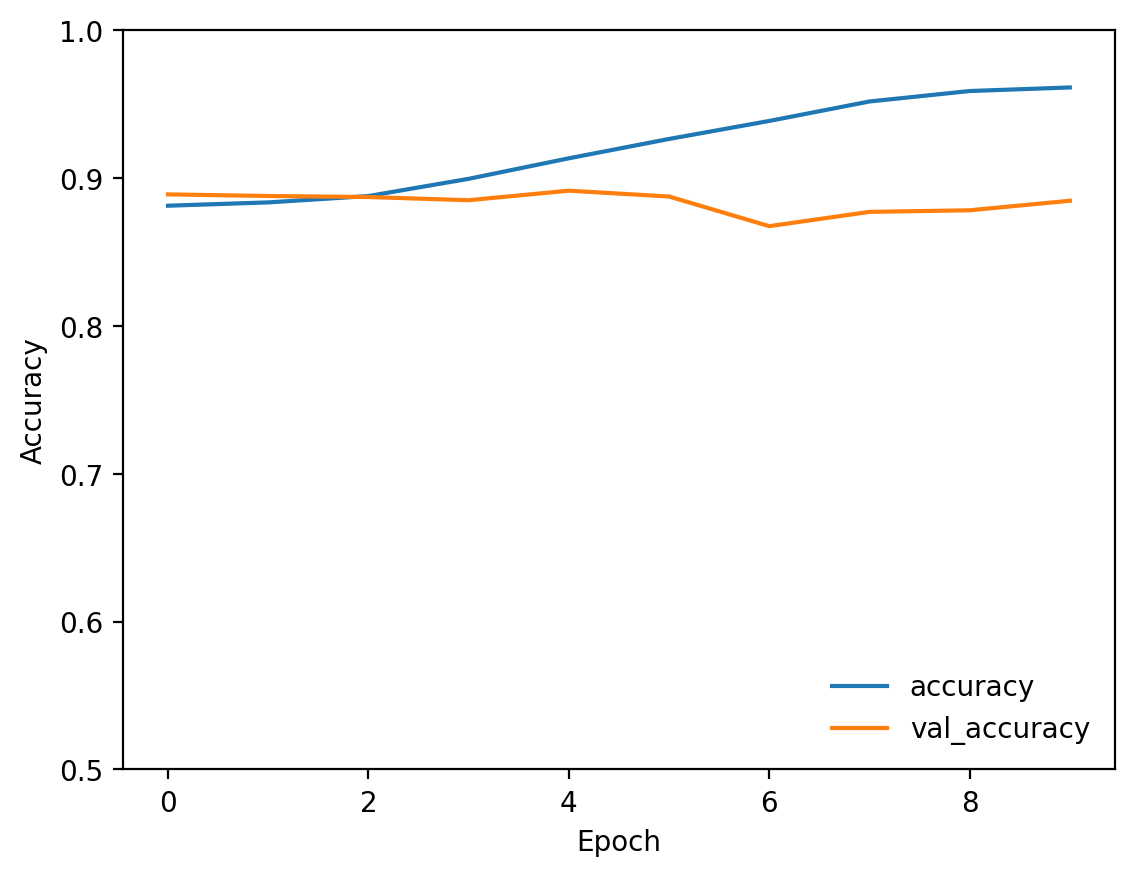

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [ ]:
print('DIS accuracy')
test_loss, test_acc = model.evaluate(DIS_test_images,  DIS_test_labels, verbose=2)
print('QE accuracy')
test_loss, test_acc = model.evaluate(QE_test_images,  QE_test_labels, verbose=2)

DIS accuracy
49/49 - 3s - loss: 0.0598 - accuracy: 0.9831 - 3s/epoch - 54ms/step
QE accuracy
11/11 - 1s - loss: 0.0250 - accuracy: 0.9971 - 501ms/epoch - 46ms/step


In [ ]:
acc = []
prec = []
for t in range(0,16):
    index=np.where(olabels==t)[0]
    if len(index) > 0:  # Ensure there are images for this energy level
        pred = model.predict(image[index]).flatten()
        pred_labels = (pred > 0.5).astype(int)
        accuracy = accuracy_score(labels[index], pred_labels)
        precision = precision_score(labels[index], pred_labels, zero_division=0)  # Handle division by zero
        acc.append(accuracy)
        prec.append(precision)



4/4 [==============================] - 0s 33ms/step


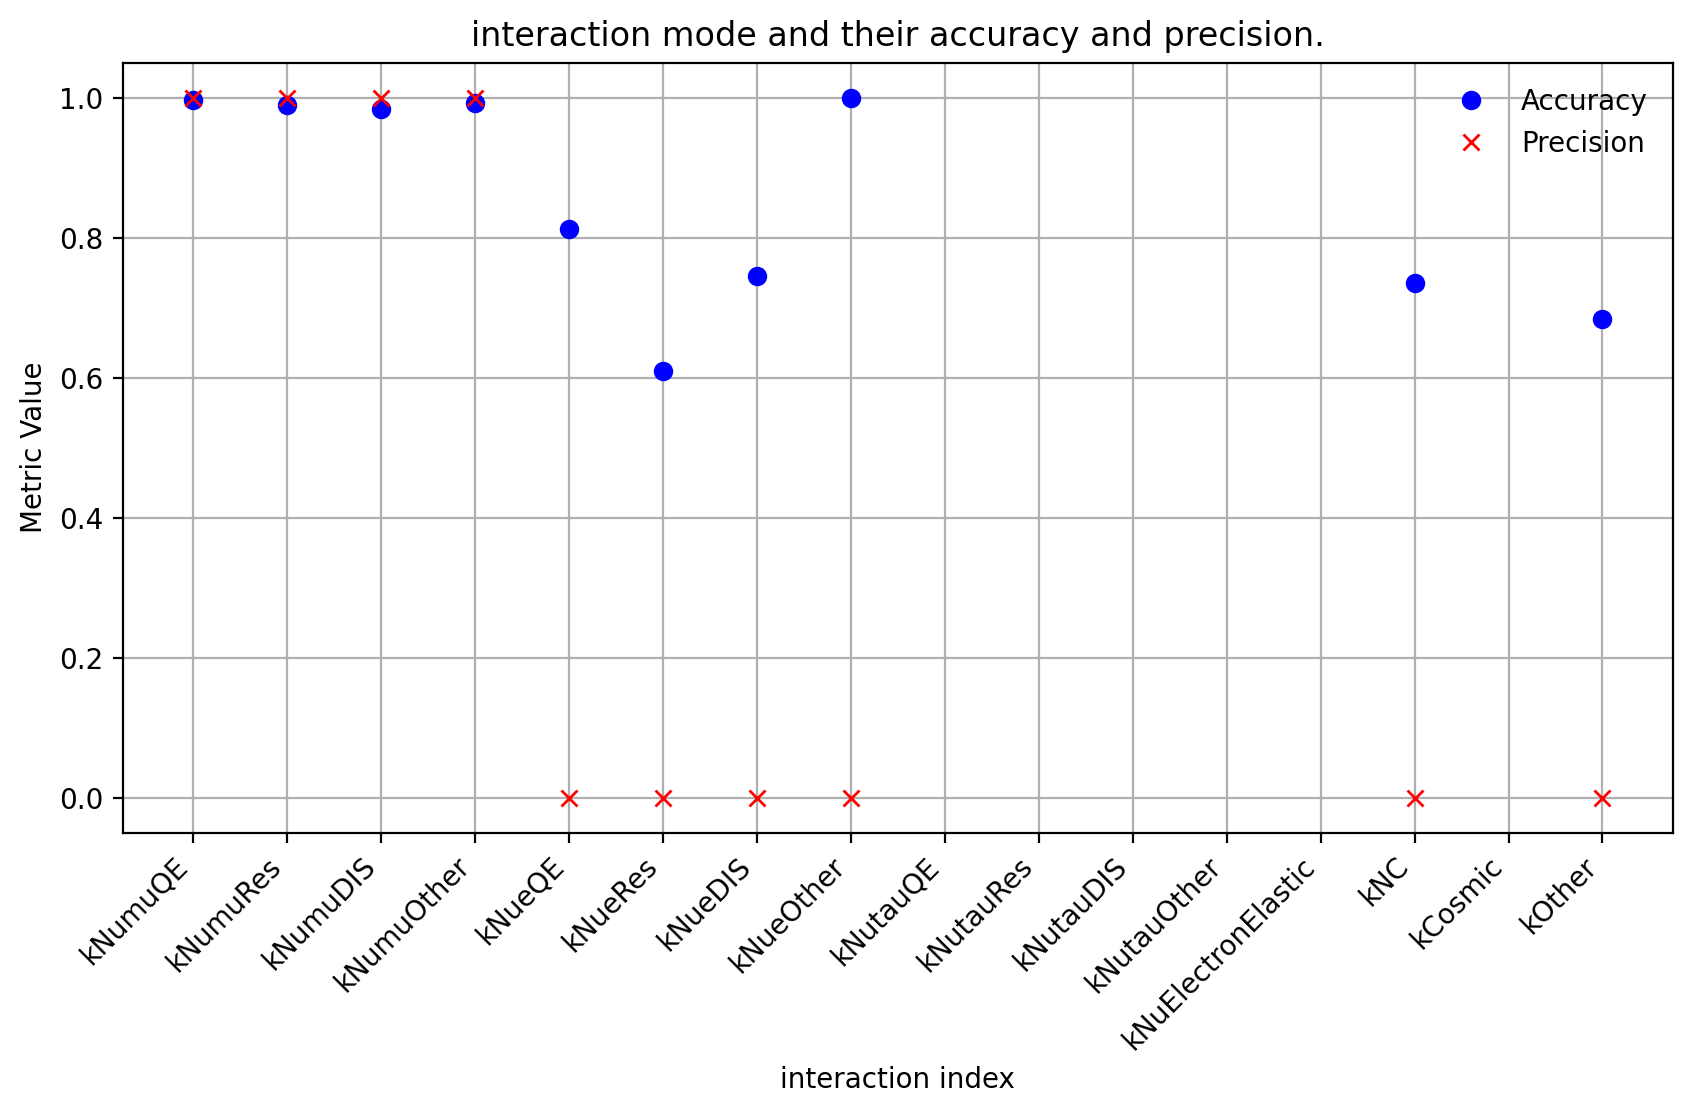

In [ ]:
plt.figure(figsize=(10, 5))  # Optional: Adjust figure size
plt.plot(np.unique(olabels), acc, marker='o', linestyle='', color='blue', label='Accuracy')
plt.plot(np.unique(olabels), prec, marker='x', linestyle='', color='red', label='Precision')
plt.xticks(range(len(interaction_names)), interaction_names, rotation=45, ha="right")
plt.xlabel('interaction index')
plt.ylabel('Metric Value')
plt.title('interaction mode and their accuracy and precision.')
plt.legend()
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 41ms/step


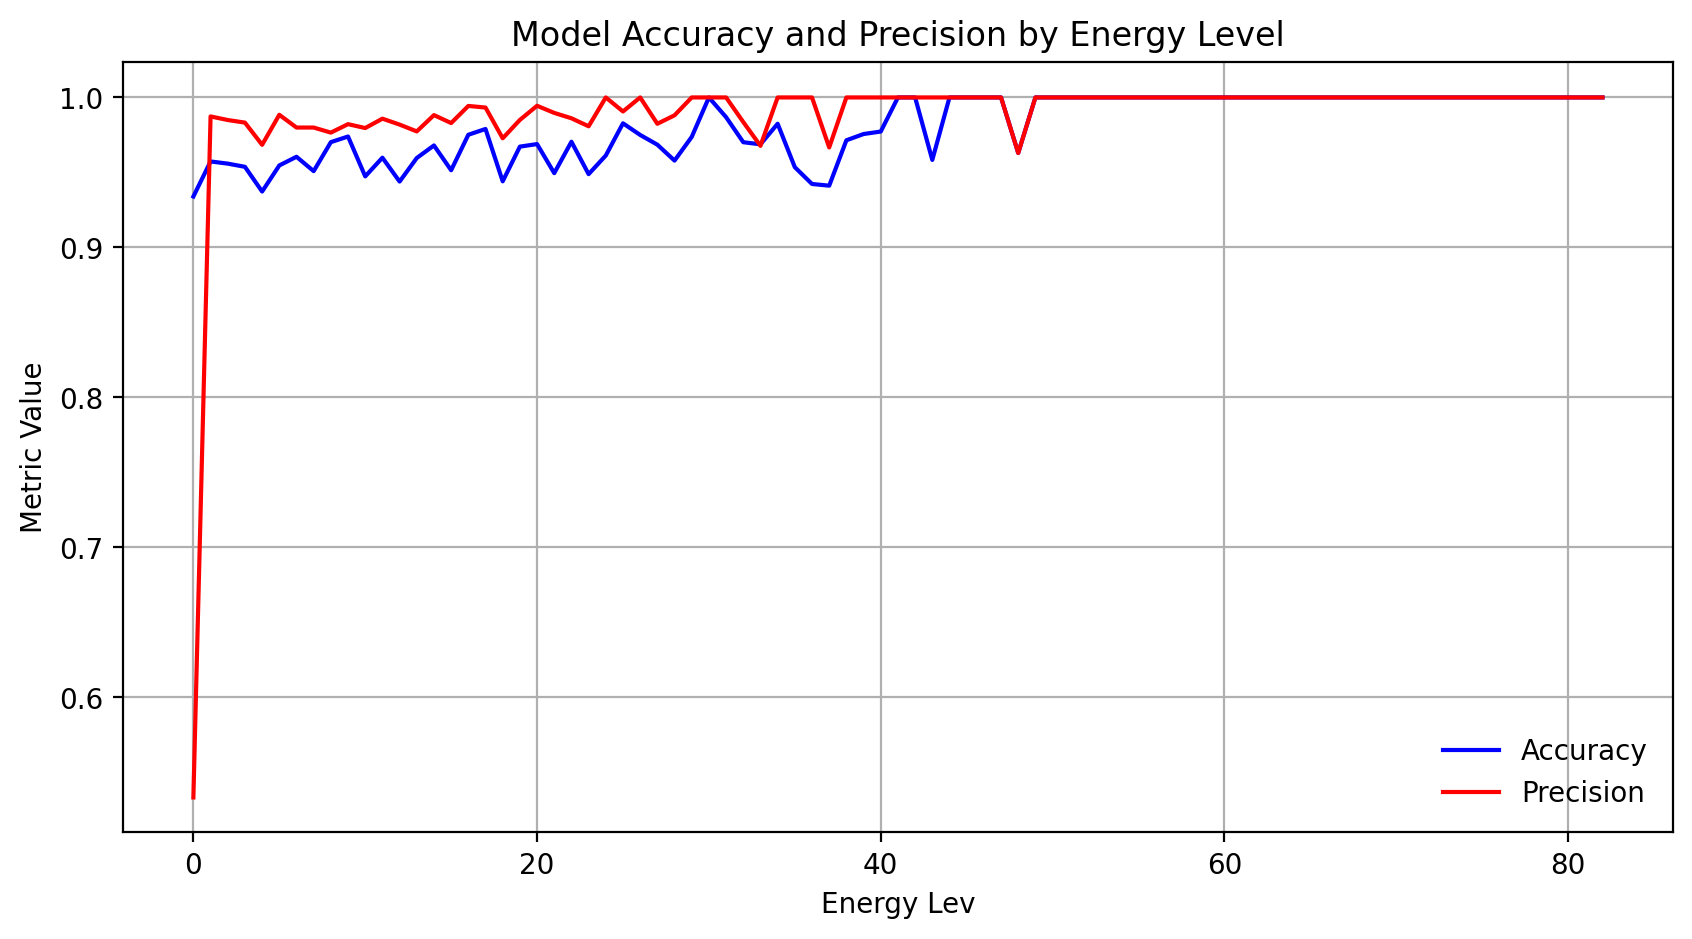

In [ ]:
narray = np.round(nuenergy )

# Initialize lists to store accuracies and precisions
acc = []
prec = []
# Energy ranges for plotting
energy_ranges = []

# Create energy intervals and calculate accuracies and precisions for each
for i in np.unique(narray):  # Ensure each energy level is only processed once
    index = np.where(narray == i)[0]
    if len(index) > 0:  # Ensure there are images for this energy level
        pred = model.predict(image[index]).flatten()
        pred_labels = (pred > 0.5).astype(int)
        accuracy = accuracy_score(labels[index], pred_labels)
        precision = precision_score(labels[index], pred_labels, zero_division=0)  # Handle division by zero
        acc.append(accuracy)
        prec.append(precision)
        energy_ranges.append(i)  # Store the energy level for plotting



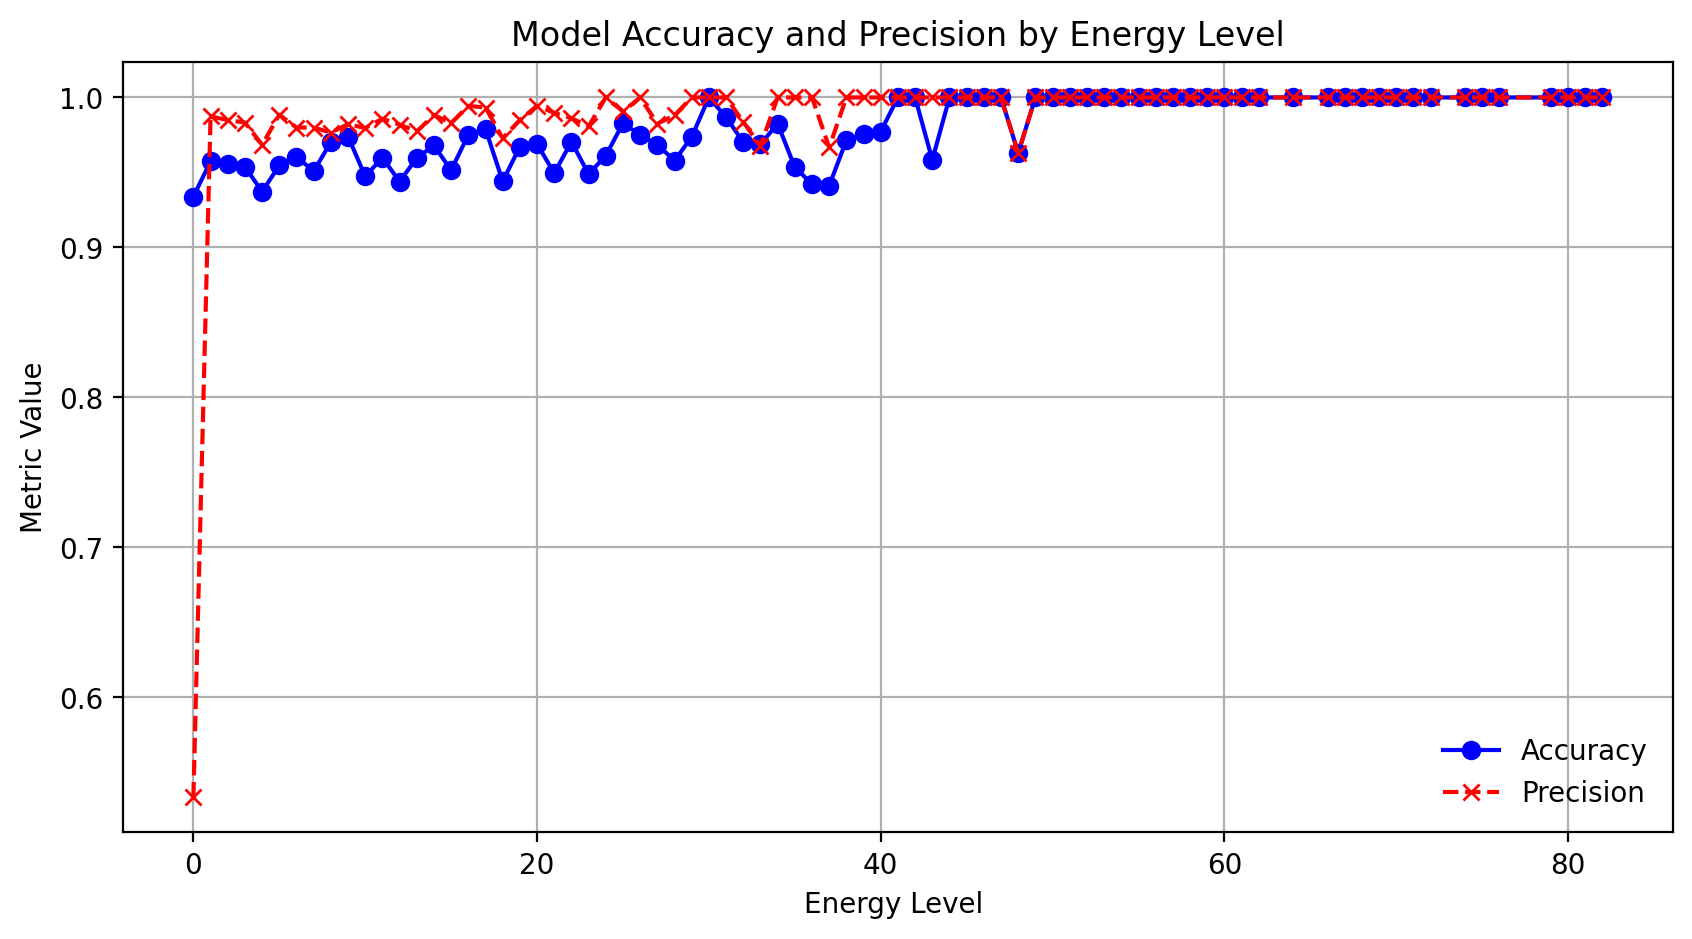

In [ ]:
# Plot accuracies and precisions against the energy levels
plt.figure(figsize=(10, 5))  # Optional: Adjust figure size
plt.plot(energy_ranges, acc, marker='o', linestyle='-', color='blue', label='Accuracy')
plt.plot(energy_ranges, prec, marker='x', linestyle='--', color='red', label='Precision')
plt.xlabel('Energy Level ')
plt.ylabel('Metric Value')
plt.title('Model Accuracy and Precision by Energy Level')
plt.legend()
plt.grid(True)
plt.show()

The model works for both high energy and low energy as they both have an accuracy above 95%.

extension 1 neutrino energy

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(image, nuenergy, test_size=0.2, random_state=42)

In [ ]:
model1 = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 80, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # 1 units for energy prediction
])


model1.compile(optimizer='adam', loss='mse', metrics=['mae']) # MAE = Mean Absolute Error

In [ ]:
history = model1.fit(train_images,train_labels , epochs=20,
                    validation_data=(test_images, test_labels))


Epoch 1/20
349/349 [==============================] - 91s 257ms/step - loss: 96.1153 - mae: 7.1191 - val_loss: 85.1283 - val_mae: 6.5505
Epoch 2/20
349/349 [==============================] - 77s 221ms/step - loss: 84.0651 - mae: 6.6259 - val_loss: 77.5262 - val_mae: 6.3887
Epoch 3/20
349/349 [==============================] - 81s 233ms/step - loss: 74.1732 - mae: 6.2021 - val_loss: 77.0181 - val_mae: 6.3190
Epoch 4/20
349/349 [==============================] - 79s 227ms/step - loss: 61.8834 - mae: 5.6458 - val_loss: 75.2941 - val_mae: 6.3589
Epoch 5/20
349/349 [==============================] - 78s 225ms/step - loss: 49.4944 - mae: 5.0536 - val_loss: 73.6081 - val_mae: 6.2095
Epoch 6/20
349/349 [==============================] - 77s 221ms/step - loss: 39.8931 - mae: 4.5320 - val_loss: 71.1036 - val_mae: 6.0604
Epoch 7/20
349/349 [==============================] - 76s 218ms/step - loss: 32.4268 - mae: 4.0740 - val_loss: 70.5876 - val_mae: 5.9525
Epoch 8/20
349/349 [=====================

Text(0, 0.5, 'Mean Absolute Error')

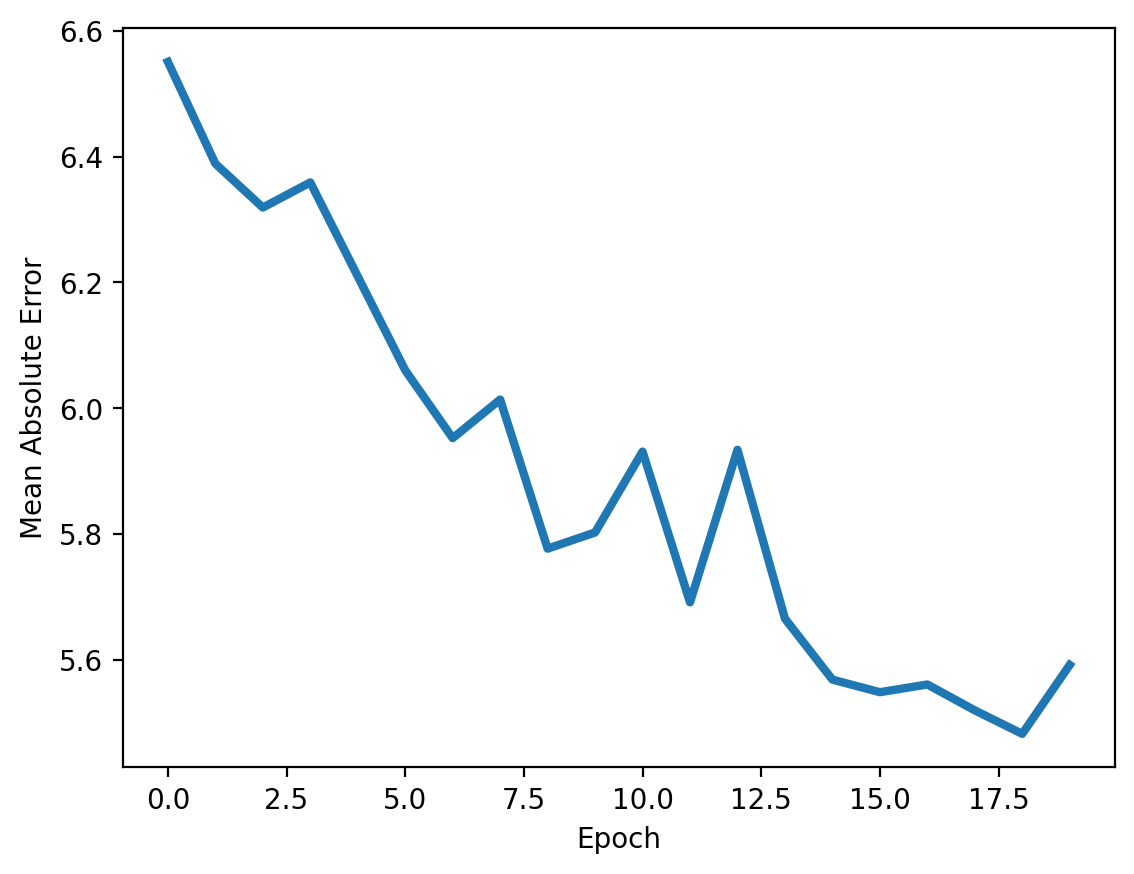

In [ ]:
fig,ax=plt.subplots()
ax.plot(history.history['val_mae'], linewidth=3)
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean Absolute Error")

extension.2
flavour
classifier to find  the flavour of the neutrino

In [40]:
def group_interactions(labels):
    # Maps the original interaction types to four categories
    grouped_labels = np.where(labels <= 3, 0,  # mu
                              np.where(labels <= 7, 1,  # electron
                                       np.where(labels <= 11, 2, 3)))  # tau, noise
    return grouped_labels

# Assuming `labels` is a numpy array of your original labels
grouped_labels = group_interactions(olabels)


In [35]:
model2 = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 80, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 units for 'mu', 'electron', 'tau', 'noise'
])

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/10
349/349 [==============================] - 76s 216ms/step - loss: 0.3767 - accuracy: 0.8766 - val_loss: 0.3132 - val_accuracy: 0.8857
Epoch 2/10
349/349 [==============================] - 70s 201ms/step - loss: 0.2890 - accuracy: 0.8848 - val_loss: 0.3359 - val_accuracy: 0.8718
Epoch 3/10
349/349 [==============================] - 76s 219ms/step - loss: 0.2500 - accuracy: 0.8927 - val_loss: 0.3544 - val_accuracy: 0.8893
Epoch 4/10
349/349 [==============================] - 71s 204ms/step - loss: 0.2093 - accuracy: 0.9119 - val_loss: 0.3592 - val_accuracy: 0.8832
Epoch 5/10
349/349 [==============================] - 72s 207ms/step - loss: 0.1713 - accuracy: 0.9263 - val_loss: 0.3980 - val_accuracy: 0.8700
Epoch 6/10
349/349 [==============================] - 71s 202ms/step - loss: 0.1340 - accuracy: 0.9445 - val_loss: 0.4492 - val_accuracy: 0.8857
Epoch 7/10
349/349 [==============================] - 71s 204ms/step - loss: 0.1058 - accuracy: 0.9582 - val_loss: 0.6010 - val_ac

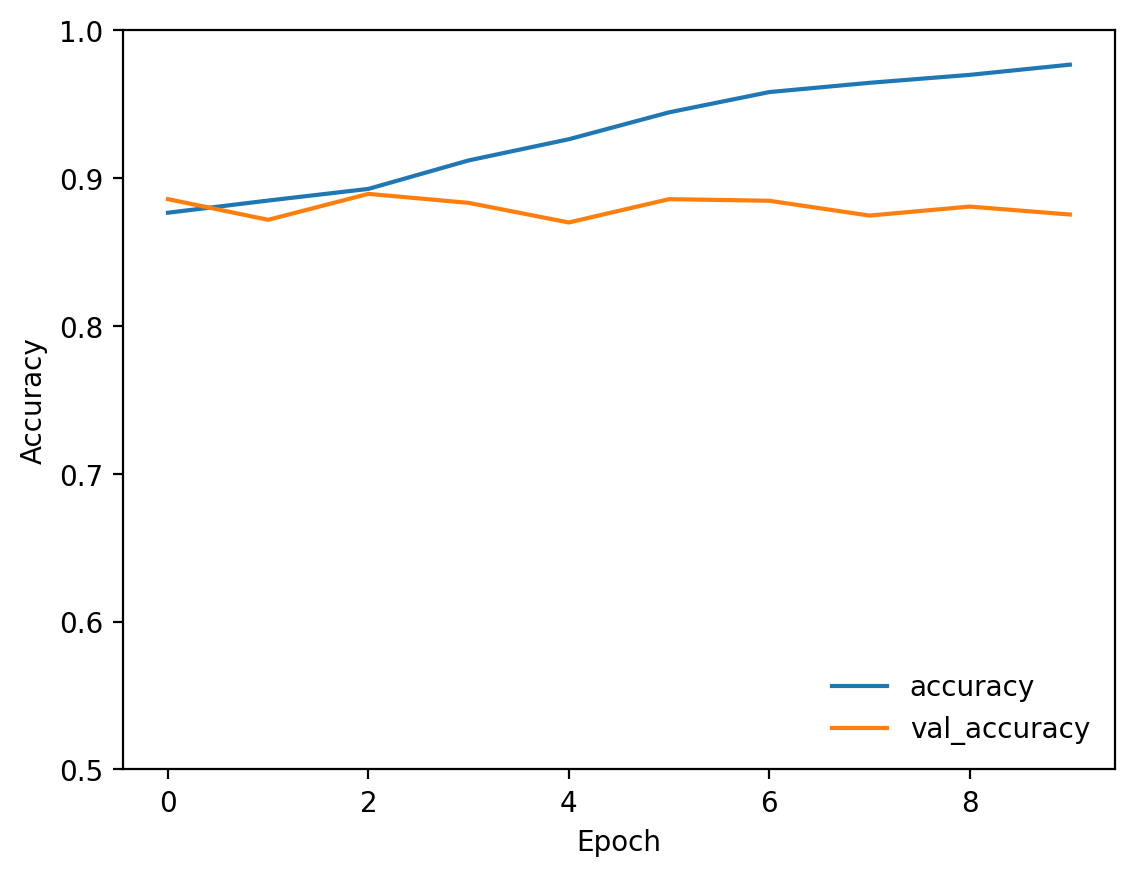

In [36]:
train_images, test_images, train_labels, test_labels = train_test_split(image, grouped_labels, test_size=0.2, random_state=42)

# Assuming images are already preprocessed (e.g., normalized)
history = model2.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
test_loss, test_acc = model2.evaluate(test_images, test_labels)

88/88 [==============================] - 4s 50ms/step - loss: 0.6792 - accuracy: 0.8779


extension 3 Determine the ratio between lepton energy and neutrino energy

The nuetrinos are seperate to 3 flavour using model2 defined in extension2 and studied their energy ratio seperately.


In [41]:
lepenergy1=df1['neutrino']['lepenergy']
lepenergy2=df2['neutrino']['lepenergy']
lepenergy=np.concatenate((lepenergy1,lepenergy2),axis=0)
y=lepenergy/nuenergy



<ipython-input-41-0952e3044606>:4: RuntimeWarning: invalid value encountered in divide
  y=lepenergy/nuenergy


In [42]:
#mu
mlabel=olabels[np.where((grouped_labels==0))[0]]
mimage=image[np.where((grouped_labels==0))[0]]
mnuenergy=nuenergy[np.where((grouped_labels==0))[0]]
mlepenergy=lepenergy[np.where((grouped_labels==0))[0]]
my=mlepenergy/mnuenergy
#e
elabel=olabels[np.where((grouped_labels==1))[0]]
eimage=image[np.where((grouped_labels==1))[0]]
enuenergy=nuenergy[np.where((grouped_labels==1))[0]]
elepenergy=lepenergy[np.where((grouped_labels==1))[0]]
ey=elepenergy/enuenergy
#tau
timageslabel=olabels[np.where((grouped_labels==2))[0]]
timage=image[np.where((grouped_labels==2))[0]]
tnuenergy=nuenergy[np.where((grouped_labels==2))[0]]
tlepenergy=lepenergy[np.where((grouped_labels==2))[0]]
ty=tlepenergy/tnuenergy

In [43]:
#prepare model that predict the energy ratio for CC mu, tau, e neutrino and all other cases.
modelm = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 80, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # 1 units for energy prediction
])
modelm.compile(optimizer='adam', loss='mse', metrics=['mae'])

modele = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 80, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # 1 units for energy prediction
])
modele.compile(optimizer='adam', loss='mse', metrics=['mae'])

modelt = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 80, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # 1 units for energy prediction
])
modelt.compile(optimizer='adam', loss='mse', metrics=['mae'])

modeln = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 80, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # 1 units for energy prediction
])
modeln.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [46]:
mtrain_images, mtest_images, mtrain_labels, mtest_labels = train_test_split(mimage,my, test_size=0.2, random_state=42)
etrain_images, etest_images, etrain_labels, etest_labels = train_test_split(eimage,ey, test_size=0.2, random_state=42)
#ttrain_images, ttest_images, ttrain_labels, ttest_labels = train_test_split(timage,ty, test_size=0.2, random_state=42) #since we dont have tau in original data file



Epoch 1/10
309/309 [==============================] - 64s 201ms/step - loss: 0.7053 - mae: 0.5521 - val_loss: 0.6158 - val_mae: 0.7568
Epoch 2/10
309/309 [==============================] - 62s 200ms/step - loss: 0.1805 - mae: 0.3636 - val_loss: 0.3903 - val_mae: 0.6175
Epoch 3/10
309/309 [==============================] - 67s 215ms/step - loss: 0.1005 - mae: 0.2701 - val_loss: 0.2707 - val_mae: 0.5200
Epoch 4/10
309/309 [==============================] - 70s 225ms/step - loss: 0.0740 - mae: 0.2340 - val_loss: 0.2163 - val_mae: 0.4641
Epoch 5/10
309/309 [==============================] - 64s 208ms/step - loss: 0.0679 - mae: 0.2231 - val_loss: 0.1942 - val_mae: 0.4378
Epoch 6/10
309/309 [==============================] - 79s 255ms/step - loss: 0.0670 - mae: 0.2206 - val_loss: 0.1871 - val_mae: 0.4287
Epoch 7/10
309/309 [==============================] - 63s 204ms/step - loss: 0.0669 - mae: 0.2200 - val_loss: 0.1850 - val_mae: 0.4260
Epoch 8/10
309/309 [==============================] - 7

Text(0, 0.5, 'Mean Absolute Error')

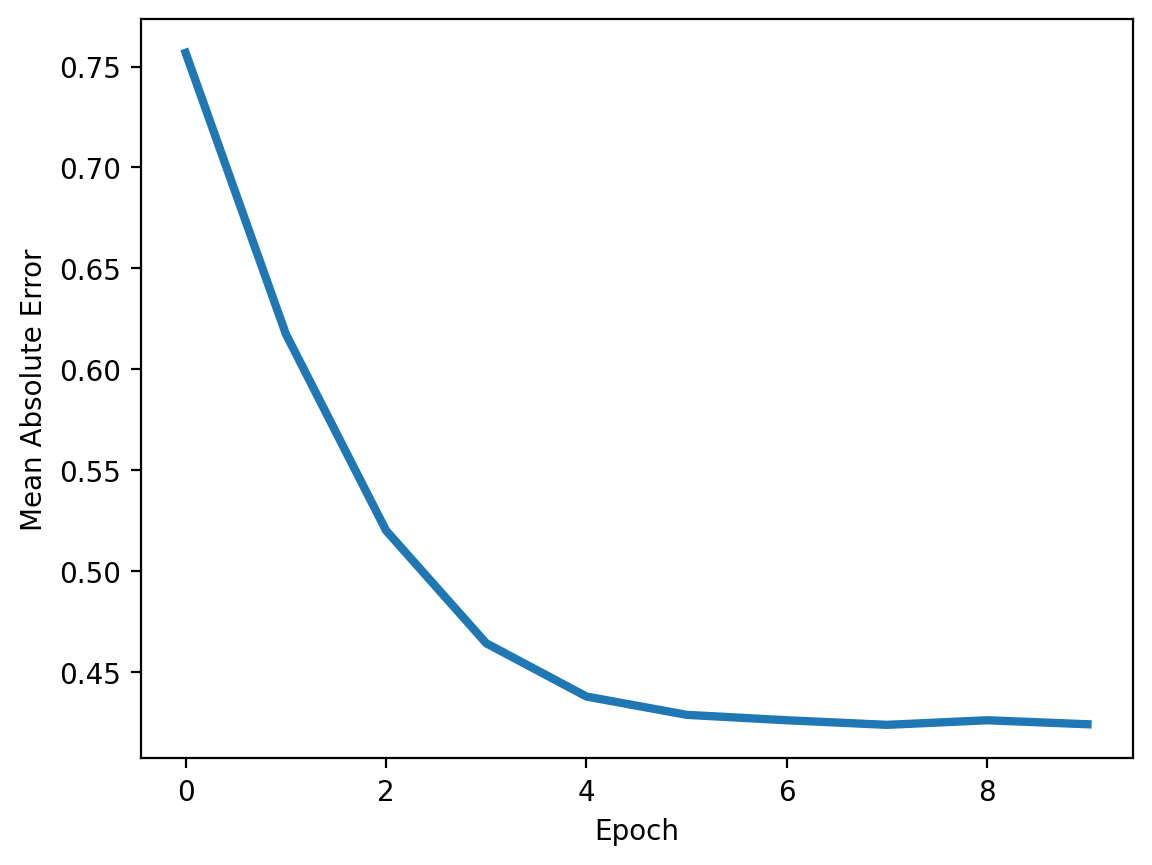

In [45]:
history = modelm.fit(mtrain_images, mtrain_labels, epochs=10, validation_data=(test_images, test_labels))

fig,ax=plt.subplots()
ax.plot(history.history['val_mae'], linewidth=3)
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean Absolute Error")

Epoch 1/10
43/43 [==============================] - 18s 414ms/step - loss: 0.0057 - mae: 0.0480 - val_loss: 0.1132 - val_mae: 0.2351
Epoch 2/10
43/43 [==============================] - 13s 297ms/step - loss: 0.0052 - mae: 0.0453 - val_loss: 0.1135 - val_mae: 0.2322
Epoch 3/10
43/43 [==============================] - 13s 316ms/step - loss: 0.0050 - mae: 0.0454 - val_loss: 0.1129 - val_mae: 0.2374
Epoch 4/10
43/43 [==============================] - 14s 318ms/step - loss: 0.0047 - mae: 0.0430 - val_loss: 0.1140 - val_mae: 0.2448
Epoch 5/10
43/43 [==============================] - 14s 317ms/step - loss: 0.0048 - mae: 0.0434 - val_loss: 0.1123 - val_mae: 0.2394
Epoch 6/10
43/43 [==============================] - 13s 294ms/step - loss: 0.0044 - mae: 0.0407 - val_loss: 0.1141 - val_mae: 0.2395
Epoch 7/10
43/43 [==============================] - 13s 315ms/step - loss: 0.0045 - mae: 0.0416 - val_loss: 0.1126 - val_mae: 0.2438
Epoch 8/10
43/43 [==============================] - 14s 318ms/step - 

Text(0, 0.5, 'Mean Absolute Error')

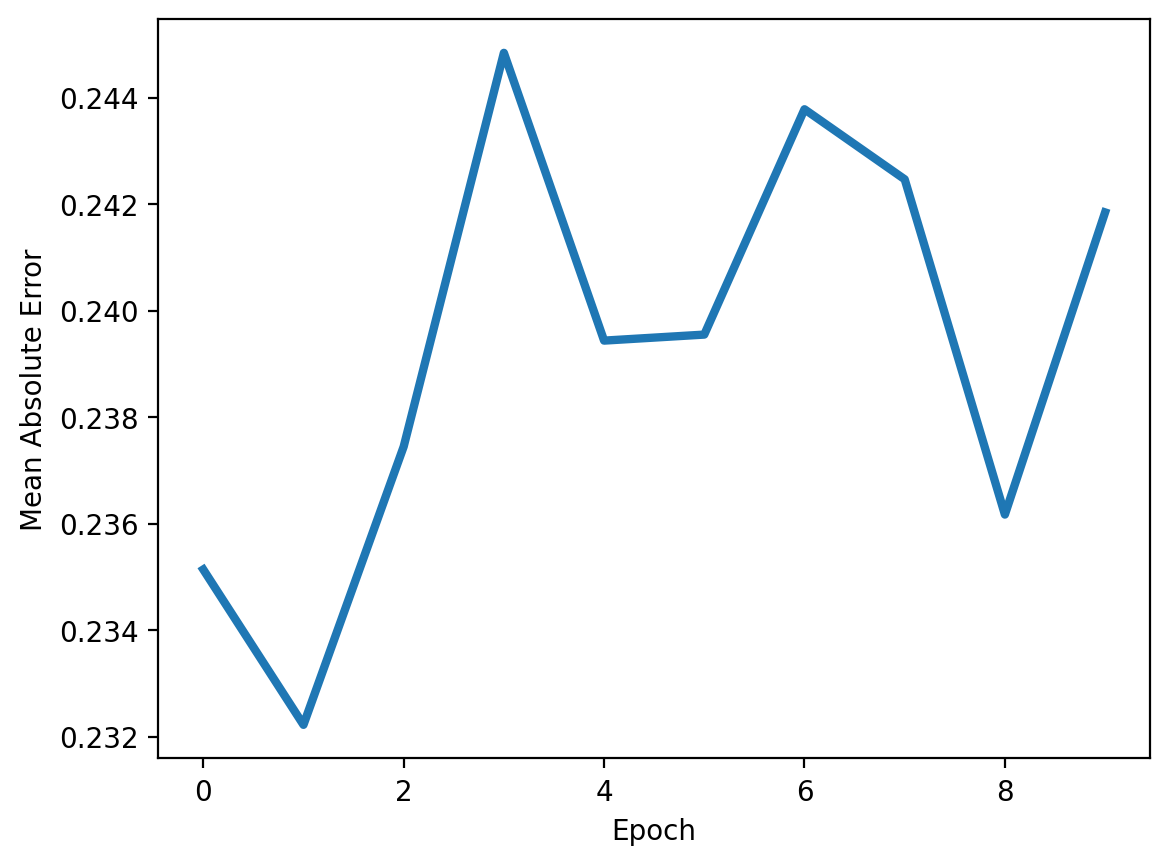

In [38]:
history = modele.fit(etrain_images, etrain_labels, epochs=10, validation_data=(test_images, test_labels))

fig,ax=plt.subplots()
ax.plot(history.history['val_mae'], linewidth=3)
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean Absolute Error")

Epoch 1/10
68/68 [==============================] - 19s 278ms/step - loss: 0.0900 - mae: 0.2597 - val_loss: 0.2663 - val_mae: 0.5159
Epoch 2/10
68/68 [==============================] - 26s 378ms/step - loss: 0.0777 - mae: 0.2401 - val_loss: 0.2433 - val_mae: 0.4932
Epoch 3/10
68/68 [==============================] - 23s 340ms/step - loss: 0.0682 - mae: 0.2246 - val_loss: 0.2242 - val_mae: 0.4730
Epoch 4/10
68/68 [==============================] - 21s 317ms/step - loss: 0.0611 - mae: 0.2121 - val_loss: 0.2084 - val_mae: 0.4551
Epoch 5/10
68/68 [==============================] - 25s 369ms/step - loss: 0.0558 - mae: 0.2023 - val_loss: 0.1953 - val_mae: 0.4392
Epoch 6/10
68/68 [==============================] - 21s 303ms/step - loss: 0.0520 - mae: 0.1945 - val_loss: 0.1845 - val_mae: 0.4253
Epoch 7/10
68/68 [==============================] - 20s 293ms/step - loss: 0.0492 - mae: 0.1887 - val_loss: 0.1758 - val_mae: 0.4134
Epoch 8/10
68/68 [==============================] - 18s 264ms/step - 

Text(0, 0.5, 'Mean Absolute Error')

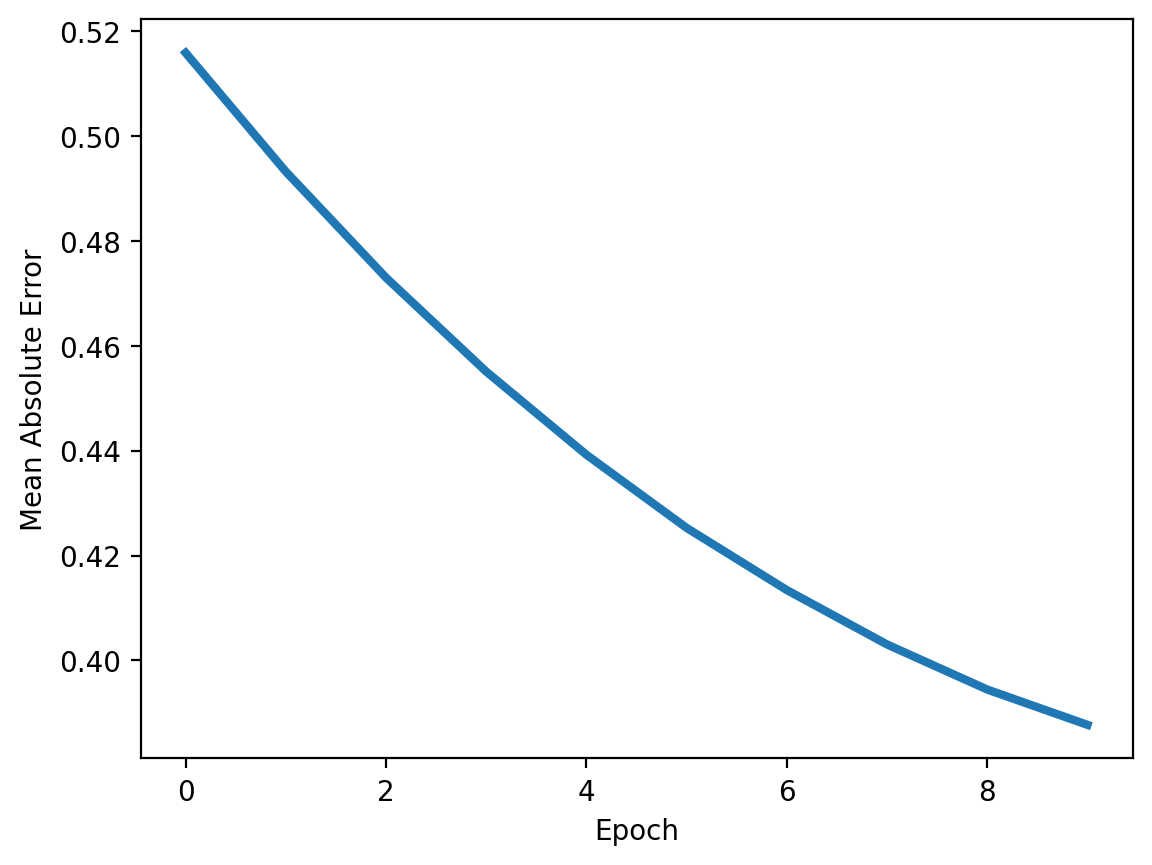

In [36]:
history = modelt.fit(ttrain_images, ttrain_labels, epochs=10, validation_data=(test_images, test_labels))

fig,ax=plt.subplots()
ax.plot(history.history['val_mae'], linewidth=3)
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean Absolute Error")


In [ ]:
def model3(input_image):
    flavor_predictions = model2.predict(input_image)
    predicted_flavor = np.argmax(flavor_predictions, axis=-1)
    # Assuming the flavors are encoded as 0 for 'mu', 1 for 'e', and 2 for 'tau', 3 for all other cases
    if predicted_flavor == 0:
        ratio_prediction = modelm.predict(input_image)
    elif predicted_flavor == 1:
        ratio_prediction = modele.predict(input_image)
    elif predicted_flavor == 2:
        ratio_prediction = modelt.predict(input_image)
    elif predicted_flavor == 3:
        ratio_prediction = modeln.predict(input_image)
    return ratio_prediction




In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming test_images are your input images and ratio are the true ratio values for these images
predictions = np.array([model3(img) for img in image])

# Calculate metrics
mse = mean_squared_error(my, predictions)
mae = mean_absolute_error(my, predictions)

print("Test MSE:", mse)
print("Test MAE:", mae)

In [ ]:
plt.plot(mnuenergy,my,'.')
plt.xlabel('neutrino energy')
plt.ylabel('ratio of lepton energy/ neutrino energy')


*extension* 5
determine the interaction mode

In [27]:
def group_interactionsmode(labels):
    # Define conditions for the new groupings
    conditions = [
        np.isin(labels, [2, 6, 10]),  # DIS
        np.isin(labels, [0, 4, 8]),   # QE
        np.isin(labels, [1, 5, 9])    # RE
    ]

    # Define the group value for each condition
    choices = [
        0,  # DIS
        1,  # QE
        2   # RE
    ]

    # Default group for all other cases (could be 'Other' or a specific group like 'Cosmic' or 'NC')
    default = 3

    # Apply conditions and choices
    grouped_labels = np.select(conditions, choices, default=default)

    return grouped_labels
model_labels=group_interactionsmode(olabels)


In [15]:
model5 = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 80, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 units for DIS, QE,RE, 'noise'
])

model5.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
train_images, test_images, train_labels, test_labels = train_test_split(image,model_labels, test_size=0.2, random_state=42)

Epoch 1/10
349/349 [==============================] - 84s 235ms/step - loss: 1.1420 - accuracy: 0.5452 - val_loss: 1.0829 - val_accuracy: 0.5541
Epoch 2/10
349/349 [==============================] - 72s 207ms/step - loss: 1.0240 - accuracy: 0.5618 - val_loss: 1.0823 - val_accuracy: 0.5591
Epoch 3/10
349/349 [==============================] - 71s 204ms/step - loss: 0.9149 - accuracy: 0.6032 - val_loss: 1.0758 - val_accuracy: 0.5609
Epoch 4/10
349/349 [==============================] - 70s 201ms/step - loss: 0.7488 - accuracy: 0.6833 - val_loss: 1.1627 - val_accuracy: 0.5484
Epoch 5/10
349/349 [==============================] - 70s 201ms/step - loss: 0.5906 - accuracy: 0.7525 - val_loss: 1.3224 - val_accuracy: 0.5774
Epoch 6/10
349/349 [==============================] - 77s 220ms/step - loss: 0.4527 - accuracy: 0.8183 - val_loss: 1.4820 - val_accuracy: 0.5684
Epoch 7/10
349/349 [==============================] - 75s 216ms/step - loss: 0.3692 - accuracy: 0.8535 - val_loss: 1.6846 - val_ac

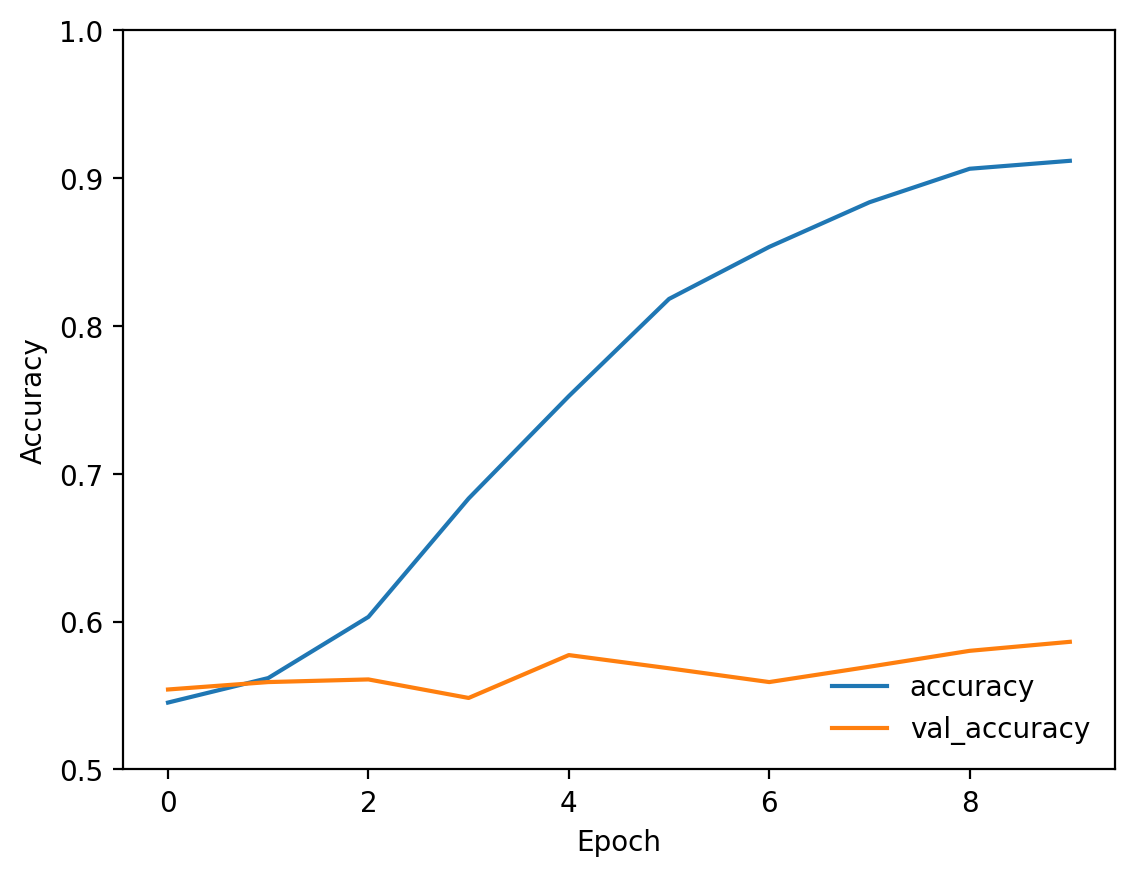

In [17]:
history = model5.fit(train_images, train_labels, epochs=15, validation_data=(test_images, test_labels))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')